In [1]:
import time

In [2]:
%%capture
!pip install torchmetrics

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.probability import FreqDist
import tensorflow as tf

import spacy
import gensim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from torchmetrics import F1Score

In [4]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Загрузка датасетов:

In [ ]:
true_data = pd.read_csv("/content/True.csv")

In [ ]:
fake_data = pd.read_csv("/content/Fake.csv")

Присвоение категорий (1 - фейк, 0 - реальная новость):

In [ ]:
true_data['target'] = 0

In [ ]:
fake_data['target'] = 1

In [ ]:
true_data.shape

(21417, 5)

In [ ]:
fake_data.shape

(23481, 5)

In [ ]:
true_data.sample(5)

,title,text,subject,date,target
5129,Sessions to respond in writing to questions ov...,WASHINGTON (Reuters) - U.S. Attorney General J...,politicsNews,"March 3, 2017",0
7856,Adviser rules out Trump meeting North Korea's ...,WASHINGTON (Reuters) - An adviser to Donald Tr...,politicsNews,"October 12, 2016",0
5150,"Trump's EPA budget proposal targets climate, l...",WASHINGTON (Reuters) - The White House is prop...,politicsNews,"March 2, 2017",0
3809,U.S. airlines meet with Homeland Security on e...,WASHINGTON (Reuters) - U.S. Homeland Security ...,politicsNews,"May 11, 2017",0
2879,China's Xi tells Trump stronger ties good for ...,BEIJING (Reuters) - Chinese President Xi Jinpi...,politicsNews,"July 8, 2017",0


In [ ]:
fake_data.sample(5)

,title,text,subject,date,target
7907,Watch Ben Carson Tell CNN He’s Ready To Use M...,After Donald Trump declared that he would do f...,News,"February 23, 2016",1
18190,FACTORY WORKER RIPS INTO Speaker Paul Ryan on ...,We love this guy! Factory worker Keith Ketzler...,left-news,"Aug 7, 2017",1
17889,NEW VIDEO…ANTIFA Terror Group INFILTRATED…Tran...,Steven Crowder is an amazing and ALWAYS unafra...,left-news,"Sep 29, 2017",1
5657,Trump Supporter: Fire All The ‘Hibi-Jabis’ Fr...,Donald Trump s anti-Muslim rhetoric has been t...,News,"July 1, 2016",1
19612,WOW! WHITE Liberals Suggest Blacks Are Too Stu...,,left-news,"Nov 15, 2016",1


Анализ имеющихся категорий. Видно, что politicsNews и politics могут быть одной категорией. Возможно их стоит объединить.

In [ ]:
true_data['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [ ]:
fake_data['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

Соединение датасетов в один:

In [ ]:
data = pd.concat([fake_data, true_data])

In [ ]:
data['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Соединим заголовок и саму новость:

In [ ]:
data['full_news'] = data['title'] + ' ' + data['text']

Убедимся в сбалансированности:

In [186]:
data['target'].value_counts()

1    23481
0    21417
Name: target, dtype: int64

In [ ]:
data.head(5)

,title,text,subject,date,target,full_news
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...


Уберем ненужные столбцы:

In [ ]:
data = data.drop(['title', 'text', 'subject', 'date'], axis=1)

In [9]:
data.shape

(10000, 3)

#Очистим новости от нежелательных символов и слов:

In [52]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

In [110]:
%%time

data['cleaned_news'] = data['full_news'].apply(lambda x: ' '.join(token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct # удаление пунктуации
        and not token.is_digit # удаление цифр
        and not token.like_email # удаление почтовых адресов
        and not token.like_num # удаление чисел, в том числе в виде текста
        and not token.is_space # удаление пробельных символов
    )
)

CPU times: user 6min 33s, sys: 721 ms, total: 6min 34s
Wall time: 6min 37s


#Токенизация:

In [188]:
data['text_tokens'] = data['cleaned_news'].apply(lambda x: gensim.utils.simple_preprocess(x)).to_list()

In [191]:
data.sample(5)

,target,cleaned_news,text_tokens
27913,0,senate panel delay vote trump trade nominee li...,"[senate, panel, delay, vote, trump, trade, nom..."
7524,1,donald trump isis attack rally hoax blown wide...,"[donald, trump, isis, attack, rally, hoax, blo..."
3261,1,woman stabs black man face christmas offer tra...,"[woman, stabs, black, man, face, christmas, of..."
12544,1,wow reckless hillary senior aide leave classif...,"[wow, reckless, hillary, senior, aide, leave, ..."
14564,1,obama visit u.s. mosque raises questions extre...,"[obama, visit, mosque, raises, questions, extr..."


In [192]:
data.shape

(44898, 3)

#Разделение данных:

In [193]:
data_train, data_test_val = train_test_split(data, shuffle=True, random_state=1234, train_size=0.7)
data_test, data_val = train_test_split(data_test_val, shuffle=True, random_state=1234, train_size=0.5)

In [194]:
data_train.shape, data_test.shape, data_val.shape

((31428, 3), (6735, 3), (6735, 3))

In [195]:
X_train = data_train[['cleaned_news', 'text_tokens']]
y_train = data_train['target']

X_val = data_val[['cleaned_news', 'text_tokens']]
y_val = data_val['target']

X_test = data_test[['cleaned_news', 'text_tokens']]
y_test = data_test['target']

In [196]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((31428, 2), (31428,), (6735, 2), (6735,), (6735, 2), (6735,))

In [197]:
y_train.value_counts()

1    16430
0    14998
Name: target, dtype: int64

In [198]:
y_test.value_counts()

1    3509
0    3226
Name: target, dtype: int64

In [199]:
X_train.sample(5)

,cleaned_news,text_tokens
33257,u.s. court poise overturn virginia ex governor...,"[court, poise, overturn, virginia, ex, governo..."
36357,emperor hirohito memoir buy japan surgeon crit...,"[emperor, hirohito, memoir, buy, japan, surgeo..."
24288,senator paul suffer broken rib assault report ...,"[senator, paul, suffer, broken, rib, assault, ..."
18266,wow video emerges hillary clinton admit foreig...,"[wow, video, emerges, hillary, clinton, admit,..."
10895,abc shuts conservative tim allen man standing”...,"[abc, shuts, conservative, tim, allen, man, st..."


Возьмем максимальную длину новости, равную 1000 слов.

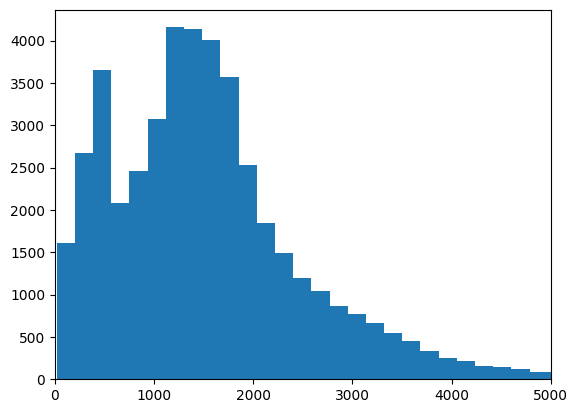

In [200]:
plt.hist([len(x) for x in data['cleaned_news']], bins=200)

plt.xlim(0, 5000)
plt.show()

In [201]:
max_length = 1000

Преобразуем токенизированный текст в числовую последовательность:

In [202]:
tokens_filtered = []

In [203]:
for sentence in X_train['text_tokens']:
  for word in sentence:
    if word.isalnum():
      tokens_filtered.append(word)

In [204]:
tokens_filtered[:10]

['liberian',
 'slum',
 'resident',
 'demand',
 'change',
 'president',
 'monrovia',
 'reuters',
 'cram',
 'tumble']

In [205]:
max_words = 2000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [206]:
len(tokens_filtered_top)

1999

In [207]:
tokens_filtered_top[:10]

['say',
 'trump',
 'president',
 'state',
 'people',
 'year',
 'new',
 'obama',
 'clinton',
 'tell']

In [208]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [209]:
len(vocabulary)

1999

In [210]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [211]:
X_train_seq = np.array([text_to_sequence(text, max_length) for text in tqdm(X_train['cleaned_news'])], dtype=np.int32)
X_test_seq = np.array([text_to_sequence(text, max_length) for text in tqdm(X_test['cleaned_news'])], dtype=np.int32)
X_val_seq = np.array([text_to_sequence(text, max_length) for text in tqdm(X_val['cleaned_news'])], dtype=np.int32)

100%|██████████| 6735/6735 [00:07<00:00, 849.60it/s]


In [212]:
y_train_seq = y_train.values
y_test_seq = y_test.values
y_val_seq = y_val.values

In [213]:
X_train_seq.shape, X_test_seq.shape, X_val_seq.shape, y_train_seq.shape, y_test_seq.shape, y_val_seq.shape

((31428, 1000), (6735, 1000), (6735, 1000), (31428,), (6735,), (6735,))

In [214]:
class TextDataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

#Создаем модели CNN и LSTM

In [215]:
batch_size = 128
epochs = 10

In [216]:
train_dataset = TextDataWrapper(X_train_seq, y_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TextDataWrapper(X_val_seq, y_val_seq)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

CNN

In [217]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [218]:
model = ConvTextClassifier()
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
f1 = F1Score(task="binary")

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")

    temp_loss = []
    temp_metrics = []
    for i, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        data = data
        target = target
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        temp_loss.append(loss.float().item())
        temp_metrics.append(f1(output.argmax(1), target).item())

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()
    print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')

ConvTextClassifier(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 305538
Train epoch 1/10


100%|██████████| 246/246 [05:31<00:00,  1.35s/it]


Loss: 0.04697468584416173, f1 score: 0.9808800564548834
Train epoch 2/10


100%|██████████| 246/246 [05:30<00:00,  1.34s/it]


Loss: 0.005338349221396928, f1 score: 0.9986463688253387
Train epoch 3/10


100%|██████████| 246/246 [05:31<00:00,  1.35s/it]


Loss: 0.009172505248471139, f1 score: 0.9982967517240261
Train epoch 4/10


100%|██████████| 246/246 [05:45<00:00,  1.41s/it]


Loss: 0.04741475463015289, f1 score: 0.9966107131989022
Train epoch 5/10


100%|██████████| 246/246 [05:40<00:00,  1.38s/it]


Loss: 0.05336567590914393, f1 score: 0.9975819405986042
Train epoch 6/10


100%|██████████| 246/246 [05:34<00:00,  1.36s/it]


Loss: 0.026787983236171313, f1 score: 0.9986865988107232
Train epoch 7/10


100%|██████████| 246/246 [05:34<00:00,  1.36s/it]


Loss: 0.060654664464699824, f1 score: 0.9985417648544156
Train epoch 8/10


100%|██████████| 246/246 [05:33<00:00,  1.36s/it]


Loss: 0.027379915705290067, f1 score: 0.9993898815255824
Train epoch 9/10


100%|██████████| 246/246 [05:34<00:00,  1.36s/it]


Loss: 0.011131157183965764, f1 score: 0.9995100684766847
Train epoch 10/10


100%|██████████| 246/246 [05:35<00:00,  1.36s/it]

Loss: 0.08993922804075082, f1 score: 0.9986514344932588


LSTM

In [219]:
class LSTM(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=100, hidden_dim=64, num_layers=1, num_classes=2):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        h_0 = torch.zeros(1, x.size(0), 64)
        c_0 = torch.zeros(1, x.size(0), 64)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc1(out[:, -1, :])
        out = torch.sigmoid(out)
        return out


model_lstm = LSTM()
optimizer = optim.Adam(model_lstm.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    print(f"Train epoch {epoch}/{epochs}")

    temp_loss = []
    temp_metrics = []

    epoch_loss = 0
    for i, (data, target) in enumerate(tqdm(train_loader)):


        optimizer.zero_grad()

        data = data
        target = target
        output = model_lstm(data)

        loss = criterion(output.squeeze().float(), target)
        loss.backward()

        optimizer.step()
        temp_loss.append(loss.float().item())
        temp_metrics.append(f1(output.argmax(1), target).item())

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()

    print(f'Avg Loss: {epoch_loss}, f1 score: {epoch_f1}')

Train epoch 0/10


100%|██████████| 246/246 [15:33<00:00,  3.79s/it]


Avg Loss: 0.4034934135956493, f1 score: 0.9117237520896322
Train epoch 1/10


100%|██████████| 246/246 [10:13<00:00,  2.49s/it]


Avg Loss: 0.3395970506154425, f1 score: 0.9743027439931544
Train epoch 2/10


100%|██████████| 246/246 [06:59<00:00,  1.71s/it]


Avg Loss: 0.33645793638093685, f1 score: 0.9766385334778608
Train epoch 3/10


100%|██████████| 246/246 [09:40<00:00,  2.36s/it]


Avg Loss: 0.3194312556245463, f1 score: 0.99406235222894
Train epoch 4/10


100%|██████████| 246/246 [08:30<00:00,  2.08s/it]


Avg Loss: 0.3184114979292319, f1 score: 0.9951419665561458
Train epoch 5/10


100%|██████████| 246/246 [07:01<00:00,  1.71s/it]


Avg Loss: 0.3218438425442068, f1 score: 0.991541562041616
Train epoch 6/10


100%|██████████| 246/246 [07:18<00:00,  1.78s/it]


Avg Loss: 0.318413169161091, f1 score: 0.9950459080982984
Train epoch 7/10


100%|██████████| 246/246 [07:05<00:00,  1.73s/it]


Avg Loss: 0.3241014599315519, f1 score: 0.9886518392136426
Train epoch 8/10


100%|██████████| 246/246 [09:21<00:00,  2.28s/it]


Avg Loss: 0.31746824945860763, f1 score: 0.9960174008113581
Train epoch 9/10


100%|██████████| 246/246 [10:55<00:00,  2.66s/it]

Avg Loss: 0.316334008564794, f1 score: 0.9969913208387732


#Оценка качества

In [220]:
test_dataset = TextDataWrapper(X_test_seq, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [221]:
true_labels = []  # Список для фактических меток
predicted_labels = []  # Список для предсказанных меток

In [236]:
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            loss = criterion(output.squeeze(), target)
            total_loss += loss.item()

            predictions = output.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            total += target.size(0)
            correct += (predictions == target).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_predictions, average='binary')
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1, conf_matrix, accuracy


cnn_avg_loss, cnn_f1, cnn_conf_matrix, cnn_accuracy = evaluate_model(model, test_loader)


lstm_avg_loss, lstm_f1, lstm_conf_matrix, lstm_accuracy = evaluate_model(model_lstm, test_loader)


print("CNN metrics:")
print(f'Loss: {cnn_avg_loss}, F1 Score: {cnn_f1}, accuracy: {cnn_accuracy}\n')

print("\nLSTM metrics:")
print(f'Loss: {lstm_avg_loss}, F1 Score: {lstm_f1}, accuracy: {lstm_accuracy}\n')


CNN metrics:
Loss: 0.6604239066898357, F1 Score: 0.9954597048808173, accuracy: 99.52487008166295


LSTM metrics:
Loss: 0.3159401354924688, F1 Score: 0.9974351667141635, accuracy: 99.73273942093542



Выведем матрицы ошибок обеих моделей:

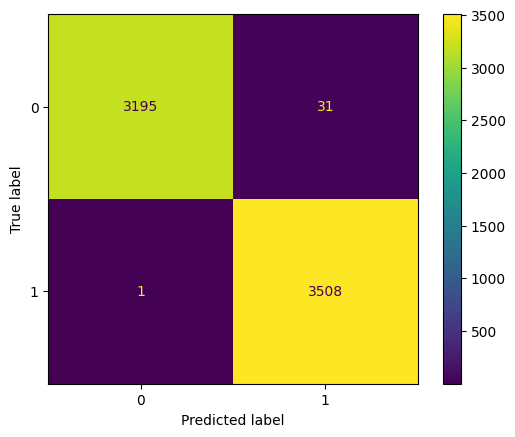

In [234]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_conf_matrix, display_labels=[0, 1])
disp.plot()
plt.show()

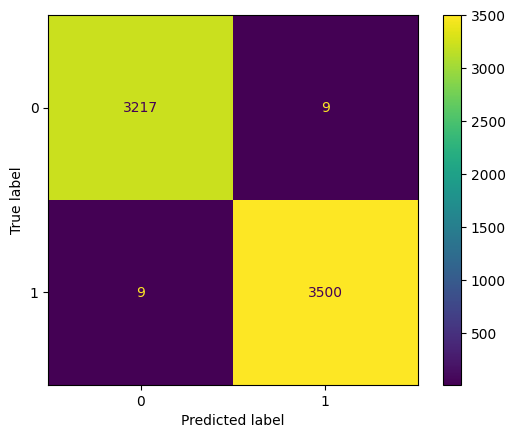

In [235]:
disp = ConfusionMatrixDisplay(confusion_matrix=lstm_conf_matrix, display_labels=[0, 1])
disp.plot()
plt.show()

Мы можем видеть, что точнее предсказания получились у модели LSTM.
В то же время эта модель пропустила больше фейков (9 против 1 у CNN модели).